## Preambule

In [1]:
# General packages
import json
from pathlib import Path

# Plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
from plotly.colors import n_colors
from plotly.subplots import make_subplots
from SALib.analyze import sobol

# Sobol analysis
from SALib.sample import saltelli
from SALib.test_functions import Ishigami
from tqdm import tqdm

## Parameters

In [2]:
params = dict(start_year_analysis=2021)
rules = ["GF", "PC", "PCC", "ECPC", "AP", "GDR"]
rulecolors = ["steelblue", "goldenrod", "forestgreen", "tomato", "sienna", "mediumvioletred"]
costoptimal_colors = ["orangered", "red", "darkred"]

## Paths

In [3]:
path_main = Path("X:/user/dekkerm/Projects/ECEMF_T5.2/")
path_data = Path("K:/ECEMF/T5.2/")
path_data_ext = Path("K:/ECEMF/T5.2/")
path_figs = path_main / "Figures" / "ECEMF_paper"

## Read data files

In [4]:
xr_2030 = xr.open_dataset("K:/ECEMF/T5.2/xr_alloc_2030.nc")
xr_2040 = xr.open_dataset("K:/ECEMF/T5.2/xr_alloc_2040.nc")
xr_FC = xr.open_dataset("K:/ECEMF/T5.2/xr_alloc_FC.nc")
all_regions_iso = np.load(path_data / "all_regions.npy")
all_regions_names = np.load(path_data / "all_regions_names.npy")
all_countries_iso = np.load(path_data / "all_countries.npy", allow_pickle=True)
all_countries_names = np.load(path_data / "all_countries_names.npy", allow_pickle=True)

## Own implementation of Saltelli

Construct samples 1 and 2 (entry choices);
* Dim 1: effort sharing [6]
* Dim 2: Scenario [5]
* Dim 3: NegEmis [7]

Total dimensions: 6x5x7 = 210. Take sample size 3.

In [5]:
uni_es = np.array(["GF", "PC", "PCC", "ECPC", "AP", "GDR"])
uni_scen = np.array(xr_2030.Scenario)
uni_conv = np.array(xr_2030.Convergence_year)
uni_risk = np.array(xr_2030.Risk)
uni_negemis = np.array(xr_2030.NegEmis)
unis = [uni_es, uni_scen, uni_conv, uni_risk, uni_negemis]
K = len(unis)
N = 1
ss = 1
total_ss = ss * len(uni_es) * len(uni_scen) * len(uni_conv) * len(uni_risk) * len(uni_negemis)

In [6]:
def define_sample():
    # Create an array of indices for each dimension
    es_indices = np.tile(
        np.arange(len(uni_es)),
        len(uni_scen) * len(uni_conv) * ss * len(uni_risk) * len(uni_negemis),
    )
    scen_indices = np.tile(
        np.repeat(np.arange(len(uni_scen)), len(uni_conv) * ss * len(uni_risk) * len(uni_negemis)),
        len(uni_es),
    )
    conv_indices = np.tile(
        np.repeat(np.arange(len(uni_conv)), ss * len(uni_risk) * len(uni_negemis)),
        len(uni_es) * len(uni_scen),
    )
    risk_indices = np.tile(
        np.repeat(np.arange(len(uni_risk)), ss * len(uni_negemis)),
        len(uni_es) * len(uni_scen) * len(uni_conv),
    )
    negemis_indices = np.tile(
        np.repeat(np.arange(len(uni_negemis)), ss),
        len(uni_es) * len(uni_scen) * len(uni_conv) * len(uni_risk),
    )

    # Create the sample1 array
    sample1 = (np.zeros((K, total_ss)) + 100).astype(str)

    # Fill the sample1 array using indices
    sample1[0] = uni_es[es_indices]
    sample1[1] = uni_scen[scen_indices]
    sample1[2] = uni_conv[conv_indices].astype(str)
    sample1[3] = uni_risk[risk_indices].astype(str)
    sample1[4] = uni_negemis[negemis_indices].astype(str)

    # Transpose and shuffle
    sample1 = sample1.T
    np.random.shuffle(sample1)
    return sample1

Compute Mnn, M1 and M2 (actual values/budgets)

In [7]:
ind_cts = np.zeros(shape=(len(all_countries_iso), K))
for reg_i, reg in enumerate(["USA", "BRA", "UGA", "CHN"]):  # tqdm(enumerate(all_countries_iso)):
    xrt = xr_2030.sel(Region=reg, Temperature=1.5)  # Budgets should not be affected by TrajUnc
    xrt = xrt - xrt.to_array().mean()
    xrt = xrt / xrt.to_array().std()
    xrt_notnorm = xr_2030.sel(Region=reg, Temperature=1.5)

    ar_xrt = np.array(xrt.to_array())
    ar_xrt_notnorm = np.array(xrt_notnorm.to_array())

    indices = np.zeros(shape=(K, N))
    for n_i in range(N):
        sample1 = define_sample().T
        sample2 = define_sample().T

        sample1_indices_dict = {}
        for idx, (es_val, scen_val, conv_val, risk_val, negemis_val) in enumerate(sample1.T):
            key = (es_val, scen_val, str(conv_val), str(risk_val), str(negemis_val))
            if key not in sample1_indices_dict:
                sample1_indices_dict[key] = []
            sample1_indices_dict[key].append(idx)

        sample1_indices_dict = {}
        for idx, (es_val, scen_val, conv_val, risk_val, negemis_val) in enumerate(sample1.T):
            key = (es_val, scen_val, str(conv_val), str(risk_val), str(negemis_val))
            if key not in sample1_indices_dict:
                sample1_indices_dict[key] = []
            sample1_indices_dict[key].append(idx)

        sample2_indices_dict = {}
        for idx, (es_val, scen_val, conv_val, risk_val, negemis_val) in enumerate(sample2.T):
            key = (es_val, scen_val, str(conv_val), str(risk_val), str(negemis_val))
            if key not in sample2_indices_dict:
                sample2_indices_dict[key] = []
            sample2_indices_dict[key].append(idx)

        sample1_sep = {}
        for key_i, key in enumerate(["ES", "SCEN", "CONV", "RISK", "NEGEMIS"]):
            sample1_sep[key] = {}
            for entry in unis[key_i]:
                sample1_sep[key][entry] = np.where(sample1[key_i] == str(entry))[0]

        sample2_sep = {}
        for key_i, key in enumerate(["ES", "SCEN", "CONV", "RISK", "NEGEMIS"]):
            sample2_sep[key] = {}
            for entry in unis[key_i]:
                sample2_sep[key][entry] = np.where(sample2[key_i] == str(entry))[0]

        M1 = np.zeros(shape=(len(sample1[0])))
        M1nn = np.zeros(shape=(len(sample1[0])))
        M2 = np.zeros(shape=(len(sample1[0])))

        N_es = np.zeros(shape=(len(sample1[0])))
        N_scen = np.zeros(shape=(len(sample1[0])))
        N_conv = np.zeros(shape=(len(sample1[0])))
        N_risk = np.zeros(shape=(len(sample1[0])))
        N_negemis = np.zeros(shape=(len(sample1[0])))
        cv = np.zeros(shape=(len(sample1[0])))

        xrt_flat = np.array(xrt.to_array()).flatten()
        xrt_notnorm_flat = np.array(xrt_notnorm.to_array()).flatten()

        for es_i, es in tqdm(enumerate(uni_es)):
            for scen_i, scen in enumerate(uni_scen):
                for conv_i, conv in enumerate(uni_conv):
                    for risk_i, risk in enumerate(uni_risk):
                        for negemis_i, negemis in enumerate(uni_negemis):
                            xrt_i = ar_xrt[es_i, negemis_i, :, risk_i, scen_i, conv_i]
                            xrt_notnorm_i = ar_xrt_notnorm[
                                es_i, negemis_i, :, risk_i, scen_i, conv_i
                            ]
                            vals = np.array(xrt_i).flatten()
                            vals_notnorm = np.array(xrt_notnorm_i).flatten()
                            wh1 = sample1_indices_dict[
                                (es, scen, str(conv), str(risk), str(negemis))
                            ]
                            wh2 = sample2_indices_dict[
                                (es, scen, str(conv), str(risk), str(negemis))
                            ]
                            choice1 = np.random.choice(range(len(vals)), ss, replace=True)
                            choice2 = np.random.choice(range(len(vals)), ss, replace=True)
                            M1nn[wh1] = vals_notnorm[choice1]
                            M1[wh1] = vals[choice1]
                            M2[wh2] = vals[choice2]

                            # First order effects
                            wh_es = np.intersect1d(
                                np.intersect1d(
                                    np.intersect1d(
                                        np.intersect1d(
                                            sample1_sep["ES"][es], sample2_sep["SCEN"][scen]
                                        ),
                                        sample2_sep["CONV"][conv],
                                    ),
                                    sample2_sep["RISK"][risk],
                                ),
                                sample2_sep["NEGEMIS"][negemis],
                            )
                            wh_scen = np.intersect1d(
                                np.intersect1d(
                                    np.intersect1d(
                                        np.intersect1d(
                                            sample2_sep["ES"][es], sample1_sep["SCEN"][scen]
                                        ),
                                        sample2_sep["CONV"][conv],
                                    ),
                                    sample2_sep["RISK"][risk],
                                ),
                                sample2_sep["NEGEMIS"][negemis],
                            )
                            wh_conv = np.intersect1d(
                                np.intersect1d(
                                    np.intersect1d(
                                        np.intersect1d(
                                            sample2_sep["ES"][es], sample2_sep["SCEN"][scen]
                                        ),
                                        sample1_sep["CONV"][conv],
                                    ),
                                    sample2_sep["RISK"][risk],
                                ),
                                sample2_sep["NEGEMIS"][negemis],
                            )
                            wh_risk = np.intersect1d(
                                np.intersect1d(
                                    np.intersect1d(
                                        np.intersect1d(
                                            sample2_sep["ES"][es], sample2_sep["SCEN"][scen]
                                        ),
                                        sample2_sep["CONV"][conv],
                                    ),
                                    sample1_sep["RISK"][risk],
                                ),
                                sample2_sep["NEGEMIS"][negemis],
                            )
                            wh_negemis = np.intersect1d(
                                np.intersect1d(
                                    np.intersect1d(
                                        np.intersect1d(
                                            sample2_sep["ES"][es], sample2_sep["SCEN"][scen]
                                        ),
                                        sample2_sep["CONV"][conv],
                                    ),
                                    sample2_sep["RISK"][risk],
                                ),
                                sample1_sep["NEGEMIS"][negemis],
                            )

                            choice_es = np.random.choice(range(len(vals)), len(wh_es), replace=True)
                            choice_scen = np.random.choice(
                                range(len(vals)), len(wh_scen), replace=True
                            )
                            choice_conv = np.random.choice(
                                range(len(vals)), len(wh_conv), replace=True
                            )
                            choice_risk = np.random.choice(
                                range(len(vals)), len(wh_risk), replace=True
                            )
                            choice_negemis = np.random.choice(
                                range(len(vals)), len(wh_negemis), replace=True
                            )

                            N_es[wh_es] = vals[choice_es]
                            N_scen[wh_scen] = vals[choice_scen]
                            N_conv[wh_conv] = vals[choice_conv]
                            N_risk[wh_risk] = vals[choice_risk]
                            N_negemis[wh_negemis] = vals[choice_negemis]

        vtot = np.var(M1nn, axis=0) / np.mean(M1nn)
        vtot_norm = np.var(M1, axis=0)
        s_es = (
            1 / (len(sample1[0]) - 1) * np.dot(M1.T, N_es)
            - 1 / (len(sample1[0])) * np.dot(M1.T, M2)
        ) / np.var(M1, axis=0)
        s_scen = (
            1 / (len(sample1[0]) - 1) * np.dot(M1.T, N_scen)
            - 1 / (len(sample1[0])) * np.dot(M1.T, M2)
        ) / np.var(M1, axis=0)
        s_conv = (
            1 / (len(sample1[0]) - 1) * np.dot(M1.T, N_conv)
            - 1 / (len(sample1[0])) * np.dot(M1.T, M2)
        ) / np.var(M1, axis=0)
        s_risk = (
            1 / (len(sample1[0]) - 1) * np.dot(M1.T, N_risk)
            - 1 / (len(sample1[0])) * np.dot(M1.T, M2)
        ) / np.var(M1, axis=0)
        s_negemis = (
            1 / (len(sample1[0]) - 1) * np.dot(M1.T, N_negemis)
            - 1 / (len(sample1[0])) * np.dot(M1.T, M2)
        ) / np.var(M1, axis=0)
        indices[:, n_i] = [s_es, s_scen, s_conv, s_risk, s_negemis]
    ind_cts[reg_i] = indices.mean(axis=1)

6it [02:43, 27.24s/it]
6it [01:32, 15.44s/it]
6it [01:36, 16.04s/it]
6it [01:34, 15.73s/it]


In [8]:
ind_cts.round(2)

array([[ 0.93, -0.  , -0.  ,  0.  ,  0.  ],
       [ 0.94, -0.  , -0.  ,  0.  , -0.  ],
       [ 0.95, -0.  , -0.  ,  0.  ,  0.  ],
       [ 0.86,  0.  , -0.  ,  0.02,  0.01],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.

## Automatic implementation

In [9]:
uni_es = np.array(["GF", "PC", "PCC", "ECPC", "AP", "GDR"])
uni_scen = np.array(xr_2030.Scenario)
uni_conv = np.array(xr_2030.Convergence_year)
uni_risk = np.array(xr_2030.Risk)
uni_negemis = np.array(xr_2030.NegEmis)
uni_traj = np.array(xr_2030.TrajUnc)

In [10]:
problem = {
    "num_vars": 6,
    "names": [
        "EffortSharing",
        "NegEmis",
        "Risk",
        "Scenario",
        "Convergence_year",
        "TrajUnc",
    ],
    "bounds": [
        [0, len(uni_es)],
        [0, len(uni_negemis)],  # Negemis len(xr_2030.NegEmis)],
        [0, len(uni_risk)],  # Risk
        [0, len(uni_scen)],  # len(xr_2030.Scenario)
        [0, len(uni_conv)],
        [0, len(uni_traj)],  # Trajunc
    ],
}

In [11]:
param_values = np.floor(saltelli.sample(problem, 2**8)).astype(int)

C:\Users\dekkerm\AppData\Local\Temp\3\ipykernel_8888\567681046.py:1: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = np.floor(saltelli.sample(problem, 2**8)).astype(int)


In [12]:
def refine_sample(pars):
    pars = param_values
    new_pars = pars.astype(str)
    v_es = uni_es[pars[:, 0]]
    v_neg = uni_negemis[pars[:, 1]]
    v_risk = uni_risk[pars[:, 2]]
    v_scen = uni_scen[pars[:, 3]]
    v_conv = uni_conv[pars[:, 4]]
    v_traj = uni_traj[pars[:, 5]]

    return np.array([v_es, v_neg, v_risk, v_scen, v_conv, v_traj]).T


def refine_sample_int(pars):
    return np.floor(param_values).astype(int)

In [13]:
def func2(pars, ar_xrt):
    vec = np.zeros(len(pars))
    for i in range(len(pars)):
        f = ar_xrt[pars[i, 0], pars[i, 1], pars[i, 5], pars[i, 2], pars[i, 3], pars[i, 4]]
        vec[i] = f
        if not np.isnan(f):
            vec[i] = f
        else:
            vec[i] = np.nan
            # f = np.nanmean(ar_xrt[pars[i, 0], pars[i, 1], :, pars[i, 2]])
            # if not np.isnan(f):
            #     vec[i] = f
            # else:
            #     f = np.nanmean(ar_xrt[:, pars[i, 1], :, pars[i, 2]])
            #     if np.isnan(f):
            #         print('CRAP')
            #     vec[i] = f
    return vec

In [16]:
Sis = np.zeros(shape=(len(all_countries_iso), 6))
xr_touse_raw = xr_2040.sel(Temperature=1.5)
for reg_i, reg in tqdm(enumerate(all_countries_iso)):
    xr_touse = xr_touse_raw.sel(Region=reg)
    ar_xrt = np.array(xr_touse.to_array())
    Y = func2(refine_sample_int(param_values), ar_xrt)
    # Y[np.isnan(Y)] = np.nanmedian(Y)
    Si = sobol.analyze(problem, Y)
    Sis[reg_i, :] = Si["ST"]
Si_norm = (Sis.T / Sis.sum(axis=1)).T
for i in range(len(Si_norm)):
    m_i = np.nanmin(Si_norm[i])
    if m_i < 0:
        Si_norm[i] = (Si_norm[i] - m_i) / np.sum((Si_norm[i] - m_i))
Si_norm[np.unique(np.where(np.isnan(Si_norm))[0])] = np.nan

3it [00:00,  7.15it/s]

197it [00:16, 11.75it/s]
C:\Users\dekkerm\AppData\Local\Temp\3\ipykernel_8888\1279337680.py:12: RuntimeWarning: All-NaN slice encountered
  m_i = np.nanmin(Si_norm[i])


In [17]:
Sis = np.zeros(shape=(len(all_countries_iso), 6))
xr_touse_raw = xr_2040.sel(Temperature=2.4)
for reg_i, reg in tqdm(enumerate(all_countries_iso)):
    xr_touse = xr_touse_raw.sel(Region=reg)
    ar_xrt = np.array(xr_touse.to_array())
    Y = func2(refine_sample_int(param_values), ar_xrt)
    # Y[np.isnan(Y)] = np.nanmedian(Y)
    Si = sobol.analyze(problem, Y)
    Sis[reg_i, :] = Si["ST"]
Si_norm_24 = (Sis.T / Sis.sum(axis=1)).T
for i in range(len(Si_norm_24)):
    m_i = np.nanmin(Si_norm_24[i])
    if m_i < 0:
        Si_norm_24[i] = (Si_norm_24[i] - m_i) / np.sum((Si_norm_24[i] - m_i))
Si_norm_24[np.unique(np.where(np.isnan(Si_norm_24))[0])] = np.nan

197it [00:14, 13.80it/s]
C:\Users\dekkerm\AppData\Local\Temp\3\ipykernel_8888\1523451169.py:12: RuntimeWarning: All-NaN slice encountered
  m_i = np.nanmin(Si_norm_24[i])


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

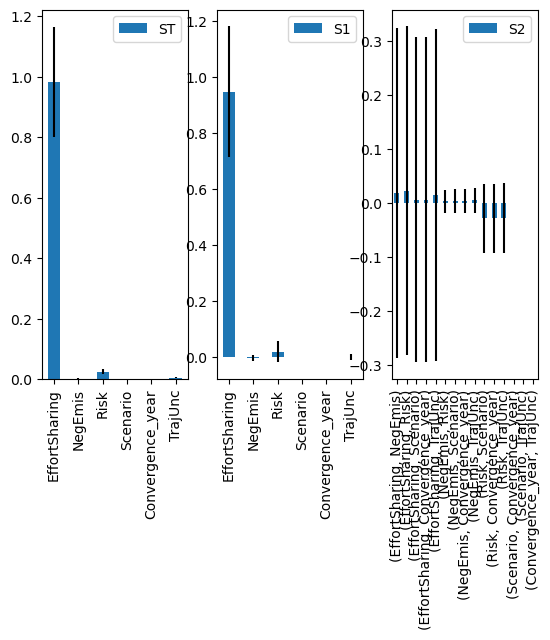

In [18]:
xr_touse = xr_touse_raw.sel(Region="MEX")
ar_xrt = np.array(xr_touse.to_array())
Y = func2(refine_sample_int(param_values), ar_xrt)
Si = sobol.analyze(problem, Y)
Si.plot()

## Plot

In [19]:
mins = [
    np.nanmin(Si_norm[:, 0]),  # Effort sharing
    np.nanmin(Si_norm[:, 1] + Si_norm[:, 2] + Si_norm[:, 5]),  # Budget / padonzekerheden
    np.nanmin(Si_norm[:, 3] + Si_norm[:, 4]),
]  # Scenario + settings
maxs = [
    np.nanmax(Si_norm[:, 0]),
    np.nanmax(Si_norm[:, 1] + Si_norm[:, 2] + Si_norm[:, 5]),
    np.nanmax(Si_norm[:, 3] + Si_norm[:, 4]),
]
mins = (np.array(mins) * 100).round(0).astype(int).astype(str)
maxs = (np.array(maxs) * 100).round(0).astype(int).astype(str)

In [20]:
def clean_data(data_in):
    """
    Cleans data in a format which can be conveniently
    used for drawing traces. Takes a dictionary as the
    input, and returns a list in the following format:

    input = {'key': ['a b c']}
    output = [key, [a, b, c]]
    """
    key = list(data_in.keys())[0]
    data_out = [key]
    for i in data_in[key]:
        data_out.append(list(map(float, i.split(" "))))

    return data_out


conts2 = []
for i in np.arange(35, 51, 5):
    conts2.append(
        {
            str(i): [
                str(i) + " " + str(i) + " " + str(100 - 2 * i),
                str(i) + " " + str(100 - 2 * i) + " " + str(i),
                str(100 - 2 * i) + " " + str(i) + " " + str(i),
            ]
        }
    )
for x in np.arange(55, 101, 5):
    conts2.append(
        {
            str(i): [
                str(x) + " " + "0" + " " + str(100 - x),
                str(x - 5) + " " + "0" + " " + str(100 - (x - 5)),
                str(x - 5) + " " + str(100 - (x - 5)) + " " + "0",
                str(x) + " " + str(100 - x) + " " + "0",
                str(x) + " " + "0" + " " + str(100 - x),
            ]
        }
    )
    conts2.append(
        {
            str(i): [
                "0" + " " + str(100 - x) + " " + str(x),
                "0" + " " + str(100 - (x - 5)) + " " + str(x - 5),
                str(100 - (x - 5)) + " " + "0" + " " + str(x - 5),
                str(100 - x) + " " + "0" + " " + str(x),
                "0" + " " + str(100 - x) + " " + str(x),
            ]
        }
    )
    conts2.append(
        {
            str(i): [
                str(100 - x) + " " + str(x) + " " + "0",
                str(100 - (x - 5)) + " " + str(x - 5) + " " + "0",
                "0" + " " + str(x - 5) + " " + str(100 - (x - 5)),
                "0" + " " + str(x) + " " + str(100 - x),
                str(100 - x) + " " + str(x) + " " + "0",
            ]
        }
    )

bar = px.colors.sequential.Greys
colors = []
for i in range(len(bar) - 1):
    colors = colors + n_colors(bar[i], bar[i + 1], int(200 / len(bar)), colortype="rgb")
colors = colors + n_colors(bar[i + 1], bar[i + 1], int(200 / len(bar)), colortype="rgb")

conttraces = []
n = 0
for raw_data in conts2:
    data = clean_data(raw_data)

    a = [inner_data[0] for inner_data in data[1:]]
    a.append(data[1][0])  # Closing the loop

    b = [inner_data[1] for inner_data in data[1:]]
    b.append(data[1][1])  # Closing the loop

    c = [inner_data[2] for inner_data in data[1:]]
    c.append(data[1][2])  # Closing the loop

    conttraces.append(
        go.Scatterternary(
            text=data[0],
            a=a,
            b=b,
            c=c,
            mode="lines",
            line=dict(color="black", width=0),
            fill="toself",
            showlegend=False,
            hoverinfo="skip",
            opacity=0.2,
            fillcolor=colors[int(200 / len(conts2) * n)],  # colors_iterator.__next__()
        )
    )
    n += 1
conttraces = conttraces[::-1]

In [21]:
args = dict(xref="paper", yref="paper", showarrow=False)
annotations = [
    dict(
        xref="paper",
        yref="paper",
        ax=0,
        align="left",
        ay=-0,
        showarrow=False,
        font=dict(color="black", size=18),
        y=0.98,
        x=0.0,
        text="<b>(a) Drivers of fair 2040 allocations</b>",
    ),
    dict(
        xref="paper",
        yref="paper",
        ax=0,
        align="left",
        ay=-0,
        showarrow=False,
        font=dict(color="black", size=18),
        y=1.005,
        x=0.99,
        text="<b>(b) Effort sharing method (" + mins[0] + "%-" + maxs[0] + "%)</b>",
    ),
    dict(
        xref="paper",
        yref="paper",
        ax=0,
        align="left",
        ay=-0,
        showarrow=False,
        font=dict(color="black", size=18),
        y=0.67,
        x=0.98,
        text="<b>(c) Budget and pathway (" + mins[1] + "%-" + maxs[1] + "%)</b>",
    ),
    dict(
        xref="paper",
        yref="paper",
        ax=0,
        align="left",
        ay=-0,
        showarrow=False,
        font=dict(color="black", size=18),
        y=0.315,
        x=1,
        text="<b>(d) Scenario and parameters (" + mins[2] + "%-" + maxs[2] + "%)</b>",
    ),
    dict(text="Effort sharing", x=0.27, y=1.03, **args, font=dict(color="darkgray", size=25)),
    dict(
        text="main uncertainty source", x=0.26, y=1.00, **args, font=dict(color="darkgray", size=16)
    ),
    dict(text="Budget and pathway", x=-0.10, y=0.0, **args, font=dict(color="darkgray", size=25)),
    dict(
        text="main uncertainty source",
        x=-0.09,
        y=-0.02,
        **args,
        font=dict(color="darkgray", size=16),
    ),
    dict(
        text="Scenario and parameters", x=0.78, y=0.0, **args, font=dict(color="darkgray", size=25)
    ),
    dict(
        text="main uncertainty source",
        x=0.78,
        y=-0.02,
        **args,
        font=dict(color="darkgray", size=16),
    ),
]

In [22]:
df_regions = pd.read_csv("X:/user/dekkerm/Data/AllCountries.csv")

In [23]:
continents = []
bubblecolors = []
for cty_i, cty in enumerate(all_countries_iso):
    cont = np.array(df_regions.region[df_regions["alpha-3"] == cty])[0]
    continents.append(cont)
    if cont == "Africa":
        bubblecolors.append("forestgreen")
    elif cont == "Europe":
        bubblecolors.append("steelblue")
    elif cont == "Asia":
        bubblecolors.append("orange")
    elif cont == "Americas":
        bubblecolors.append("plum")
    elif cont == "Oceania":
        bubblecolors.append("goldenrod")
    else:
        bubblecolors.append("silver")
continents = np.array(continents)
bubblecolors = np.array(bubblecolors)

In [24]:
xr_dataread = xr.open_dataset(path_data / "xr_dataread.nc")
pops = np.array(xr_dataread.Population.sel(Region=all_countries_iso, Time=2020, Scenario="SSP2"))
pops[np.isnan(pops)] = 1
pops_n = pops / np.nanmax(pops)

In [25]:
a = Si_norm[:, 0]
b = Si_norm[:, 1] + Si_norm[:, 2] + Si_norm[:, 5]
c = Si_norm[:, 3] + Si_norm[:, 4]

a_24 = Si_norm_24[:, 0]
b_24 = Si_norm_24[:, 1] + Si_norm_24[:, 2] + Si_norm_24[:, 5]
c_24 = Si_norm_24[:, 3] + Si_norm_24[:, 4]
# a[np.isnan(a)] = 1
# b[np.isnan(a)] = 0
# c[np.isnan(a)] = 0

In [26]:
fig = make_subplots(
    rows=3,
    cols=3,
    specs=[
        [{"type": "scatterternary", "colspan": 2, "rowspan": 3}, {}, {"type": "choropleth"}],
        [{}, {}, {"type": "choropleth"}],
        [{}, {}, {"type": "choropleth"}],
    ],
    horizontal_spacing=0,
    vertical_spacing=0.0,
)

# Panel a
for i in np.arange(0.1, 1.0, 0.1):
    args = dict(
        mode="lines",
        showlegend=False,
        hoverinfo="skip",
        marker={
            "size": 15,
            "color": "black",
            "opacity": 1,  # 0.9-i*0.03,
            "line": dict(width=0.0, color="silver"),
        },
        line={
            "width": 1,  # np.mean(s[i:i+2])*0.5,
            "color": "black",
            "dash": "dot",
        },
        textfont=dict(size=5, color="black"),
    )
    fig.add_trace(go.Scatterternary(a=[i, i], b=[0, 1 - i], c=[1 - i, 0], **args), 1, 1)
    fig.add_trace(go.Scatterternary(b=[i, i], a=[0, 1 - i], c=[1 - i, 0], **args), 1, 1)
    fig.add_trace(go.Scatterternary(c=[i, i], b=[0, 1 - i], a=[1 - i, 0], **args), 1, 1)

fig.add_trace(
    go.Scatterternary(
        a=a_24,
        b=b_24,
        c=c_24,
        mode="markers",
        showlegend=False,
        text=all_countries_iso,
        marker={
            "size": (pops_n) ** 0.4 * 60 + 4,
            "color": "grey",
            "opacity": 0.9,  # 0.9-i*0.03,
            "line": dict(width=0, color="black"),
        },
        line={
            "width": 0,  # np.mean(s[i:i+2])*0.5,
            "color": "black",
            "dash": "dot",
        },
        textfont=dict(size=(pops_n) ** 0.4 * 25 + 1, color="black"),
    ),
    1,
    1,
)

for cont_i, cont in enumerate(np.unique(continents)):
    fig.add_trace(
        go.Scatterternary(
            a=a[continents == cont],
            b=b[continents == cont],
            c=c[continents == cont],
            mode="markers+text",
            showlegend=False,
            text=all_countries_iso[continents == cont],
            marker={
                "size": (pops_n[continents == cont]) ** 0.4 * 60 + 4,
                "color": bubblecolors[continents == cont],
                "opacity": 0.9,  # 0.9-i*0.03,
                "line": dict(width=1, color="black"),
            },
            line={
                "width": 1,  # np.mean(s[i:i+2])*0.5,
                "color": "black",
                "dash": "dot",
            },
            textfont=dict(size=(pops_n[continents == cont]) ** 0.4 * 25 + 1, color="black"),
        ),
        1,
        1,
    )
# for n in range(len(conttraces)):
#         fig.add_trace(conttraces[n], 1, 1)

fig.update_layout(
    {
        "plot_bgcolor": "rgb(243, 243, 243)",
        "ternary": {
            "sum": 1,
            "bgcolor": "whitesmoke",
            # "paper_bgcolor":'rgba(0,0,0,0)',
            # "plot_bgcolor":'rgba(0,0,0,0)',
            "aaxis": {
                "title": "",
                "min": 0.5,
                "titlefont": {"size": 25},  # Climate target<br>
                "linewidth": 0,
                "ticks": "outside",
                "tickmode": "array",
                "tickvals": np.arange(0, 1.01, 0.1),
                "ticktext": [str(int(i * 100)) + "%" for i in np.arange(0, 1.01, 0.1)],
                "tickfont": {"size": 15},
            },
            "baxis": {
                "title": "",
                "min": 0,
                "titlefont": {"size": 25},  # &nbsp; &nbsp; &nbsp;#Model &nbsp; &nbsp;
                "linewidth": 2,
                "ticks": "outside",
                "tickmode": "array",
                "tickvals": np.arange(0, 1.01, 0.1),
                "ticktext": [str(int(i * 100)) + "%" for i in np.arange(0, 1.01, 0.1)],
                "tickangle": 60,
                "tickfont": {"size": 15},
            },
            "caxis": {
                "title": "",
                "min": 0,
                "titlefont": {"size": 25},  # Other<br>scenario assumptions
                "linewidth": 2,
                "ticks": "outside",
                "tickmode": "array",
                "tickvals": np.arange(0, 1.01, 0.1),
                "ticktext": [str(int(i * 100)) + "%" for i in np.arange(0, 1.01, 0.1)],
                "tickangle": -60,
                "tickfont": {"size": 15},
            },
        },
    }
)


# Panel b-d
for frac_i, frac in enumerate(["Temperature", "EffortSharing", "Parameters"]):
    if frac_i == 0:
        t = a
    if frac_i == 1:
        t = b
    if frac_i == 2:
        t = c
    # t[np.isnan(t)] = 0
    fig.add_trace(
        go.Choropleth(
            locations=all_countries_iso[~np.isnan(t)],
            z=t[~np.isnan(t)],
            locationmode="ISO-3",
            colorscale="Spectral_r",  #'RdYlGn_r',
            zmax=1,
            zmin=0,
            text=[
                str(r) + ": " + str(np.round(int(100 * t[~np.isnan(t)][r_i]))) + "%"
                for r_i, r in enumerate(all_countries_iso[~np.isnan(t)])
            ],
            hovertemplate="%{text}",
            name="",
            marker_line_color="black",
            marker_line_width=0.5,
            colorbar=dict(
                len=1,
                x=1,
                tickvals=np.arange(0, 1.01, 0.1),
                ticktext=[str(int(100 * i)) + "%" for i in np.arange(0, 1.01, 0.1)],
                tickfont={"size": 17},
                title={"text": "<b>Percentage<br>variance<br>explained", "font": {"size": 17}},
            ),
            showscale=[True, False, False][frac_i],
        ),
        [1, 2, 3][frac_i],
        [3, 3, 3][frac_i],
    )

fig.update_geos(
    visible=False,
    showlakes=True,
    lakecolor="rgb(255, 255, 255)",
    projection_type="natural earth",
    resolution=110,
    showcoastlines=False,
)

fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.29,
        xanchor="left",
        x=0.08,
        font=dict(size=15, color="black"),
    ),
    template="ggplot2",
    height=900,
    width=1600,
)
fig.update_xaxes(visible=False)

for ann in annotations:
    fig.add_annotation(**ann)
fig.update_layout(margin={"r": 0, "t": 30, "l": 150, "b": 50})

In [27]:
fig.write_image(path_figs / "Figure_2.png", scale=3)